In [200]:
from functools import partial
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from mne.datasets import sample
from mne.io import read_raw_fif
from mne import make_fixed_length_epochs

from pyriemann.estimation import Covariances
from pyriemann.clustering import Potato
from pyriemann.utils.viz import _add_alpha
from pyriemann.utils.covariance import normalize

In [255]:
from filenames_and_paths import *
import mne

# raw_fname = os.path.join(sample.data_path(), 'MEG', 'sample',
#                          'sample_audvis_filt-0-40_raw.fif')
# raw = read_raw_fif(raw_fname, preload=True, verbose=False)

raw = mne.io.read_raw_brainvision(folders.raw_data + path014 + filenames014[0] + '.vhdr', preload=True)
raw = raw.drop_channels(["EOG", "BIP1", "M1", "M2", "PO5", "PO6"])
raw.set_montage(mne.channels.make_standard_montage("biosemi64"))

raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[0] + '.set', preload=True)
raw_clean = raw_clean.drop_channels(["PO5", "PO6"])


sfreq = int(raw.info['sfreq']) 

Extracting parameters from ./raw_data/rest_14/ACP_INP0014_REST1_1pnt_1vis.vhdr...
Setting channel info structure...
Reading 0 ... 1013446  =      0.000 ...   494.847 secs...


/var/folders/tt/nr_wg20d5q13z6kxlpj2xsyc0000gn/T/ipykernel_99057/711503744.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[0] + '.set', preload=True)


In [256]:
ch_names = "Fp1"

# Apply band-pass filter between 1 and 35 Hz
raw.filter(1, 40, n_jobs=-1)
raw.set_eeg_reference(ref_channels='average', projection=True)
# raw_clean.filter(1, 20)
# Epoch time-series with a sliding window
duration = 2.5    # duration of epochs
interval = 0.2    # interval between successive epochs

epochs = make_fixed_length_epochs(
    raw, duration=duration, overlap=duration - interval, verbose=False)
epochs_data = 5e5 * epochs.get_data(copy=False)

clean_epochs = make_fixed_length_epochs(
    raw_clean, duration=duration, overlap=duration - interval, verbose=False)
clean_epochs_data = 5e5 * clean_epochs.get_data(copy=False)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Using data from preloaded Raw for 2462 events and 5120 original time points ...


[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    3.5s finished


0 bad epochs dropped
Using data from preloaded Raw for 2462 events and 5120 original time points ...
0 bad epochs dropped


In [257]:
# Estimate spatial covariance matrices
covs = Covariances(estimator='lwf').transform(epochs_data)
# covs = normalize(Covariances(estimator='lwf').transform(epochs_data), 'trace')
# clean_covs = normalize(Covariances(estimator='lwf').transform(clean_epochs_data), 'trace')

In [258]:
%matplotlib qt
# raw.plot()
# raw_clean.plot()
%matplotlib inline

In [259]:
print(covs.shape, clean_covs.shape)

(2462, 59, 59) (2462, 59, 59)


In [339]:
z_th = 1.6 #4.65      # z-score threshold
train_covs = 500  # nb of matrices to train the potato

In [340]:
# Calibrate potato by unsupervised training on first matrices: compute a
# reference matrix, mean and standard deviation of distances to this reference.
train_set = range(train_covs)
rpotato = Potato(metric='riemann', threshold=z_th).fit(covs[train_set])
# epotato = Potato(metric='euclid', threshold=z_th).fit(clean_covs[train_set])


In [341]:
# rpotato.fit_transform(covs[train_set])

In [342]:
# rp_labels = rpotato.predict(clean_covs[train_set])
# rp_proba = rpotato.predict_proba(clean_covs[train_set])
# ep_labels = epotato.predict(clean_covs[train_set])

In [343]:
# print(np.unique(rp_labels, return_counts=True))
# rp_proba

In [419]:
test_set = range(100)
rp_labels_test = rpotato.predict(covs[test_set])
rp_proba_test = rpotato.predict_proba(covs[test_set])

# ep_labels_test = epotato.predict(covs[test_set])

In [420]:
print(np.unique(rp_labels_test, return_counts=True))
rp_proba_test

(array([1.]), array([100]))


array([0.13163933, 0.13331061, 0.13538423, 0.18816349, 0.22687204,
       0.24424685, 0.27337975, 0.36016257, 0.40959508, 0.42790471,
       0.42753176, 0.46883461, 0.45174303, 0.4221895 , 0.44717054,
       0.44315376, 0.51026105, 0.51213188, 0.53244872, 0.58022634,
       0.61849863, 0.53812081, 0.50102482, 0.41335582, 0.4374357 ,
       0.42738321, 0.41561168, 0.40282528, 0.39507365, 0.37215193,
       0.36947989, 0.38232983, 0.36162416, 0.41703667, 0.4794463 ,
       0.46634348, 0.47923913, 0.43300346, 0.42125256, 0.4324643 ,
       0.39123842, 0.41191222, 0.42233026, 0.39740195, 0.46995781,
       0.43698008, 0.39582371, 0.41610163, 0.39576744, 0.46003196,
       0.48605462, 0.46970034, 0.56490375, 0.5315095 , 0.53116788,
       0.49966197, 0.47641444, 0.49889858, 0.4968817 , 0.45049697,
       0.4379508 , 0.44214104, 0.49116375, 0.49722241, 0.44956245,
       0.30080866, 0.24868993, 0.23346187, 0.23433764, 0.22624611,
       0.22749987, 0.23265568, 0.35781258, 0.46575105, 0.50300

(<matplotlib.image.AxesImage at 0x2ad1e8750>,
 <matplotlib.contour.QuadContourSet at 0x2ad0e11d0>)

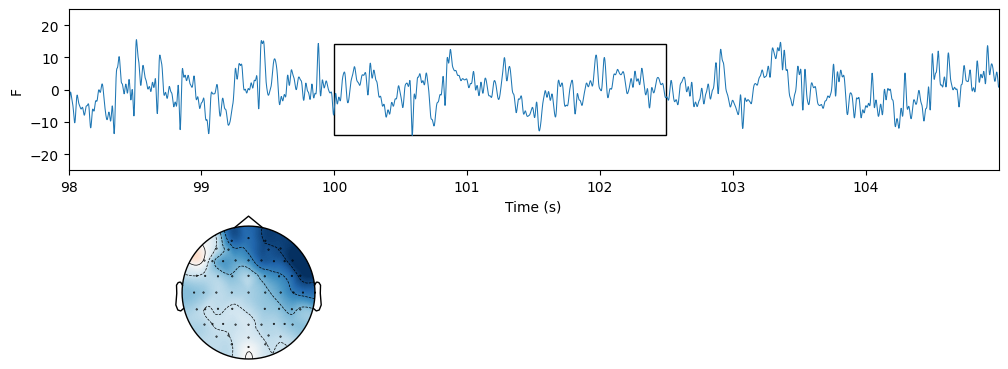

In [421]:
%matplotlib inline
def plot_sig(ax, time, sig):
    ax.axis((time[0], time[-1], -25, 25))
    pl, = ax.plot(time, sig, lw=0.75)
    ax.axhspan(
        -14, 14, edgecolor='k', facecolor='none',
        xmin=xmin,
        xmax=xmax)
    return pl


# Prepare data for online detection
test_covs_max = 600    # nb of matrices to visualize in this example
test_time_start = -2    # start time to display signal
test_time_end = 5       # end time to display signal

time_start = train_covs * interval + test_time_start
time_end = train_covs * interval + test_time_end

xmin = -test_time_start / (test_time_end - test_time_start)
xmax = (duration - test_time_start) / (test_time_end - test_time_start)

# time_start = test_time_start + 1
# time_end = test_time_end + 1 
time = np.linspace(time_start, time_end, int((time_end - time_start) * sfreq),
                   endpoint=False)

eeg_data = 3e5 * raw.get_data(picks=ch_names)
sig = eeg_data[:, int(time_start * sfreq):int(time_end * sfreq)]



fig = plt.figure(figsize=(12, 10), constrained_layout=False)
# fig.suptitle('Online artifact detection by potatoes', fontsize=16)
gs = fig.add_gridspec(nrows=4, ncols=40, top=0.90, hspace=0.3, wspace=1.0)
ax_sig0 = fig.add_subplot(gs[0, :], xlabel='Time (s)', ylabel=ch_names[0])
pl_sig0 = plot_sig(ax_sig0, time, sig[0])
text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize=16)
ax_topo = fig.add_axes([0.2, 0.55, 0.15, 0.15])

full_eeg_data = raw.get_data()
mean_eeg_in_axhspan = full_eeg_data[:, int(xmin * sfreq):int(xmax * sfreq)]
mne.viz.plot_topomap(mean_eeg_in_axhspan.T.mean(axis=0), raw.info, axes=ax_topo, show=False)

In [422]:

raw.get_data().shape

(59, 1013447)

In [423]:

def online_detect(t):
    global time, sig, covs_visu

    # Online artifact detection
    t_window = int(t-(np.ceil(duration/interval)))
    # print(t, t_window)
    rp_label = rpotato.predict(covs[np.newaxis, t_window])[0]
    rp_proba = rpotato.predict_proba(covs[np.newaxis, t_window])[0]
    # if rp_label == 1:
    # rpotato.partial_fit(covs[np.newaxis, t_window], alpha=1 / (t_window))
    time_start = t * interval + test_time_end
    time_end = (t + 1) * interval + test_time_end
    time_ = np.linspace(time_start, time_end, int(interval * sfreq),
                        endpoint=False)
    time = np.r_[time[int(interval * sfreq):], time_]
    
    sig = np.hstack((sig[:, int(interval*sfreq):],
                     eeg_data[:, int(time_start*sfreq):int(time_end*sfreq)]))

    ax_topo.clear()
    mean_eeg_in_axhspan = full_eeg_data[:, int((time_start-4.5) * sfreq):int((time_start-2.5) * sfreq)]
    mne.viz.plot_topomap(mean_eeg_in_axhspan.T.mean(axis=0).T, raw.info, axes=ax_topo, show=False)
    
    if len(time) != sig.shape[1]:
        sig = sig[:, :-1]
        # print("FIXED")
        # print(time[10:])
        # print(len(time))
        # print(sig.shape)
    pl_sig0.set_data(time, sig[0])
    print(rp_label, rp_proba)
    text.set_text(f'Potato label: {rp_label} - proba: {rp_proba},\n topos - {(time_start-5.5)}\n topoe - {(time_start-2.5)} \n t_actual {t} - {t * interval + test_time_end} \n t_predict {t_window} - {(t_window * interval) + test_time_end}')
    #map proba to different colors
    
    ax_sig0.patches[0].set_edgecolor('k' if rp_label == 1 else 'r')
    pl_sig0.axes.set_xlim(time[0], time[-1])
    return pl_sig0

potato = FuncAnimation(fig, online_detect,
                       frames=range(train_covs, test_covs_max),
                       interval=1, blit=False, repeat=False)

In [424]:
print(range(1, test_covs_max))

range(1, 600)


In [425]:
# Plot complete visu: a dynamic display is required
%matplotlib inline
plt.show()

# Plot only 10s, for animated documentation
try:
    from IPython.display import HTML
except ImportError:
    raise ImportError("Install IPython to plot animation in documentation")

plt.rcParams["animation.embed_limit"] = 100
with open("data3.html", "w") as file:
    file.write(HTML(potato.to_jshtml(fps=5, default_mode='loop')).data)

1.0 0.8479513691104063
1.0 0.8479513691104063
1.0 0.8370068489702234
1.0 0.8469836812139053
1.0 0.8192220787480631
1.0 0.8164216075773987
1.0 0.8476042859518276
1.0 0.8355736234502147
1.0 0.8356955034206732
1.0 0.8404954019315074
1.0 0.8289694151165238
1.0 0.8142924963128526
1.0 0.7407802594866189
1.0 0.7189668666273752
1.0 0.6946009540572922
1.0 0.6881935802955097
1.0 0.723843167401902
1.0 0.6425139475647259
1.0 0.6631284927092371
1.0 0.6401923401054151
1.0 0.7249100991010293
1.0 0.7625624317435551
1.0 0.7991227167376086
1.0 0.8334880258943091
1.0 0.8376659026144511
1.0 0.8370171458963693
1.0 0.8174067993472145
1.0 0.8262416248143505
1.0 0.8215266386634443
1.0 0.8068898450024502
1.0 0.7905146614437515
1.0 0.6762178571165788
1.0 0.6921738001595436
1.0 0.8385723763700144
1.0 0.882470218027296
1.0 0.8812748188806759
1.0 0.8750345298118429
1.0 0.831237128845504
1.0 0.82393477369629
1.0 0.803822953116256
1.0 0.8036328650590125
1.0 0.7862189544577434
1.0 0.7711024630749445
1.0 0.70428665263